Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Đang đọc dữ liệu từ: /content/drive/MyDrive/S1S2_cloud_training_samples_Ha_Noi City.csv...
Đã tải dữ liệu thành công!
Kích thước dữ liệu: (68000, 18)
                               system:index   B11   B12    B2    B3    B4  \
0  20230108T033119_20230108T033607_T48QWJ_0  3686  2976  6915  5879  4968   
1  20230108T033119_20230108T033607_T48QWJ_1  3909  3409  6525  5692  5100   
2  20230108T033119_20230108T033607_T48QWJ_2  2321  1959  2770  2643  2531   
3  20230108T033119_20230108T033607_T48QWJ_3  3684  3459  5879  4572  4490   
4  20230108T033119_20230108T033607_T48QWJ_4  3575  2993  6244  5215  4537   

     B8   B8A  BRIGHT      NDSI      NDVI      NDWI         VH        VV  \
0  4991  3953   17762  0.229273  0.002309  0.081693 -14.594551 -7.669741   
1  4789  4393   17317  0.185710 -0.031449  0.086156 -14.588237 -7.591538   
2  2228  2195    7944  0.06486

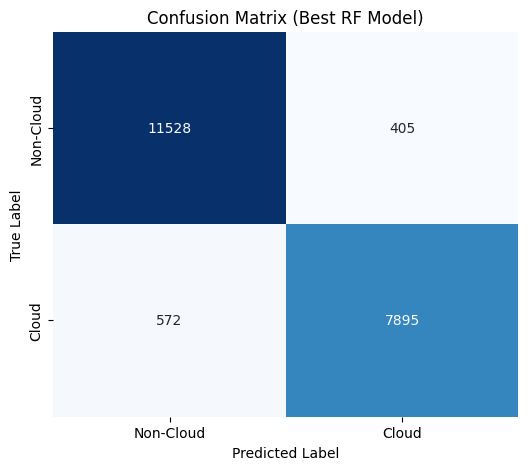


--- Feature Importance ---


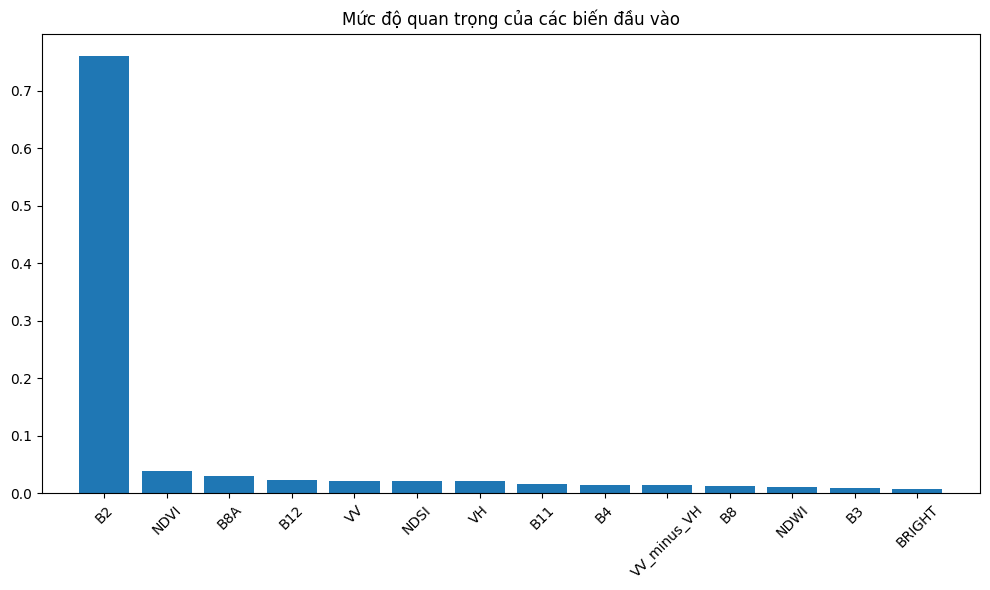

        Feature  Importance
0            B2    0.760823
1          NDVI    0.039371
2           B8A    0.029870
3           B12    0.022834
4            VV    0.022045
5          NDSI    0.021067
6            VH    0.021003
7           B11    0.015506
8            B4    0.013835
9   VV_minus_VH    0.013404
10           B8    0.011750
11         NDWI    0.011206
12           B3    0.009642
13       BRIGHT    0.007645

Đã lưu mô hình tại: /content/drive/MyDrive/S1S2_cloud_RF_model.pkl


In [ ]:
# Random forest

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

file_path = '../data/S1S2_cloud_training_samples_Ha_Noi_City.csv'

print(f"Đang đọc dữ liệu từ: {file_path}...")
try:
    df = pd.read_csv(file_path)
    print("Đã tải dữ liệu thành công!")
    print(f"Kích thước dữ liệu: {df.shape}")
except FileNotFoundError:
    print("LỖI: Không tìm thấy file. Vui lòng kiểm tra lại đường dẫn và tên file.")
print(df.head())


# Danh sách các cột đặc trưng (Feature)
feature_cols = [
    'B2', 'B3', 'B4', 'B8', 'B8A', 'B11', 'B12',
    'NDVI', 'NDWI', 'NDSI', 'BRIGHT',
    'VV', 'VH', 'VV_minus_VH'
]

target_col = 'label'

X = df[feature_cols]
y = df[target_col]

# Kiểm tra dữ liệu null/NaN (nếu có thì điền 0 hoặc bỏ qua)
if X.isnull().values.any():
    print("Phát hiện giá trị null, đang điền bằng 0...")
    X = X.fillna(0)

# Chia tập Train / Test (Tỷ lệ 70% Train - 30% Test hoặc 80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Số lượng mẫu huấn luyện: {X_train.shape[0]}")
print(f"Số lượng mẫu kiểm tra: {X_test.shape[0]}")

# HYPERPARAMETER TUNING
print("\n--- Bắt đầu quá trình Tuning tham số (GridSearchCV/RandomizedSearchCV) ---")
# Khai báo mô hình cơ sở
rf_base = RandomForestClassifier(random_state=42)
# Thiết lập lưới tham số cần thử nghiệm
param_grid = {
    'n_estimators': [100, 200, 300],          # Số lượng cây (Trees)
    'max_depth': [None, 10, 20, 30],          # Độ sâu tối đa của cây
    'min_samples_split': [2, 5, 10],          # Số mẫu tối thiểu để tách nút
    'min_samples_leaf': [1, 2, 4],            # Số mẫu tối thiểu tại nút lá
    'max_features': ['sqrt', 'log2', None]    # Số lượng feature dùng mỗi lần tách
}

# Sử dụng RandomizedSearchCV
rf_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_grid,
    n_iter=20,          # Số lượng tổ hợp ngẫu nhiên sẽ thử
    cv=5,               # Cross-validation 5-fold
    verbose=2,
    random_state=42,
    n_jobs=-1           # Sử dụng tất cả các luồng CPU
)

# Thực hiện training và tìm tham số
rf_search.fit(X_train, y_train)

# In kết quả tốt nhất
best_params = rf_search.best_params_
print("\nTHAM SỐ TỐT NHẤT TÌM ĐƯỢC:")
print(best_params)

# Lấy ra mô hình tốt nhất
best_rf_model = rf_search.best_estimator_

# ----------------------------------------------------------------------------
# 4. ĐÁNH GIÁ MÔ HÌNH (EVALUATION)
# ----------------------------------------------------------------------------
print("\n--- Đánh giá mô hình trên tập Test ---")

# Dự đoán trên tập test
y_pred = best_rf_model.predict(X_test)

# Tính độ chính xác tổng thể
acc = accuracy_score(y_test, y_pred)
print(f"Độ chính xác (Accuracy): {acc:.4f}")

# Báo cáo chi tiết (Precision, Recall, F1-score)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Cloud (0)', 'Cloud (1)']))

# Vẽ Ma trận nhầm lẫn (Confusion Matrix)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Cloud', 'Cloud'],
            yticklabels=['Non-Cloud', 'Cloud'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Best RF Model)')
plt.show()

# ĐÁNH GIÁ TẦM QUAN TRỌNG CỦA ĐẶC TRƯNG (FEATURE IMPORTANCE)
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

print("\n--- Feature Importance ---")
plt.figure(figsize=(10, 6))
plt.title("Mức độ quan trọng của các biến đầu vào")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_cols[i] for i in indices], rotation=45)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()

# In ra bảng giá trị cụ thể
feature_importance_df = pd.DataFrame({
    'Feature': [feature_cols[i] for i in indices],
    'Importance': importances[indices]
})
print(feature_importance_df)

# LƯU MÔ HÌNH
model_filename = '../models/S1S2_cloud_RF_model.pkl'
joblib.dump(best_rf_model, model_filename)
print(f"\nĐã lưu mô hình tại: {model_filename}")

Đã xuất file CSV thành công: /content/drive/MyDrive/S1S2_Feature_Importance.csv
------------------------------
        Feature  Importance
0            B2    0.760823
1          NDVI    0.039371
2           B8A    0.029870
3           B12    0.022834
4            VV    0.022045
5          NDSI    0.021067
6            VH    0.021003
7           B11    0.015506
8            B4    0.013835
9   VV_minus_VH    0.013404
10           B8    0.011750
11         NDWI    0.011206
12           B3    0.009642
13       BRIGHT    0.007645
------------------------------
Đã lưu biểu đồ ảnh thành công: /content/drive/MyDrive/S1S2_Feature_Importance_Chart.png


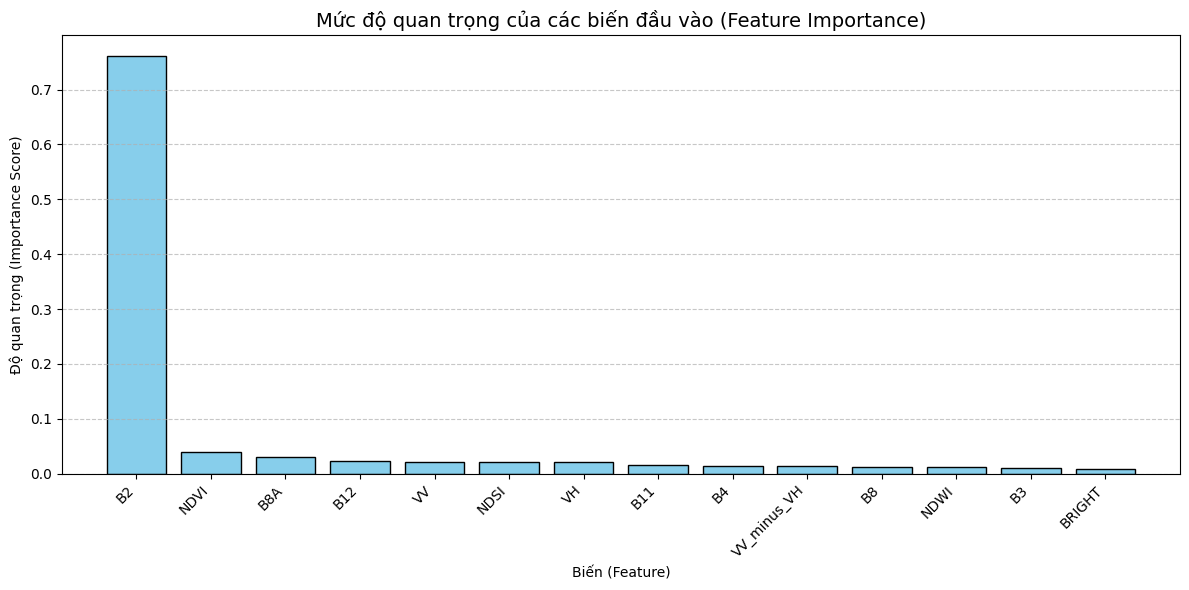

In [ ]:

# XUẤT KẾT QUẢ FEATURE
import os
output_csv_path = '../outputs/S1S2_Feature_Importance.csv'
output_img_path = '../outputs/S1S2_Feature_Importance_Chart.png'

# 1. Lưu bảng dữ liệu ra file CSV
if 'feature_importance_df' in locals():
    feature_importance_df.to_csv(output_csv_path, index=False)
    print(f"Đã xuất file CSV thành công: {output_csv_path}")
    print("-" * 30)
    print(feature_importance_df) # In lại để kiểm tra
else:
    print("LỖI: Biến 'feature_importance_df' chưa tồn tại. Vui lòng chạy cell huấn luyện mô hình trước.")

# 2. Lưu biểu đồ ra file ảnh (PNG) để báo cáo
if 'best_rf_model' in locals():
    plt.figure(figsize=(12, 6))
    indices = np.argsort(best_rf_model.feature_importances_)[::-1]
    plt.title("Mức độ quan trọng của các biến đầu vào (Feature Importance)", fontsize=14)
    plt.bar(range(X.shape[1]), best_rf_model.feature_importances_[indices], align="center", color='skyblue', edgecolor='black')
    plt.xticks(range(X.shape[1]), [feature_cols[i] for i in indices], rotation=45, ha='right')
    plt.xlabel("Biến (Feature)")
    plt.ylabel("Độ quan trọng (Importance Score)")
    plt.xlim([-1, X.shape[1]])
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Lưu ảnh
    plt.savefig(output_img_path, dpi=300)
    print("-" * 30)
    print(f"Đã lưu biểu đồ ảnh thành công: {output_img_path}")
    plt.show()
else:
    print("LỖI: Không tìm thấy mô hình để vẽ biểu đồ.")

Đang tải mô hình Random Forest...
Đã tải model thành công!
Đang đọc ảnh từ: /content/drive/MyDrive/sentinel_cloud/cloud_test.tif...
Kích thước ảnh: 2133x2004
Số bands gốc: 29
Đang tính toán các chỉ số (NDVI, NDWI...)...
Đang chạy dự đoán (Random Forest)...
Đang vẽ kết quả...


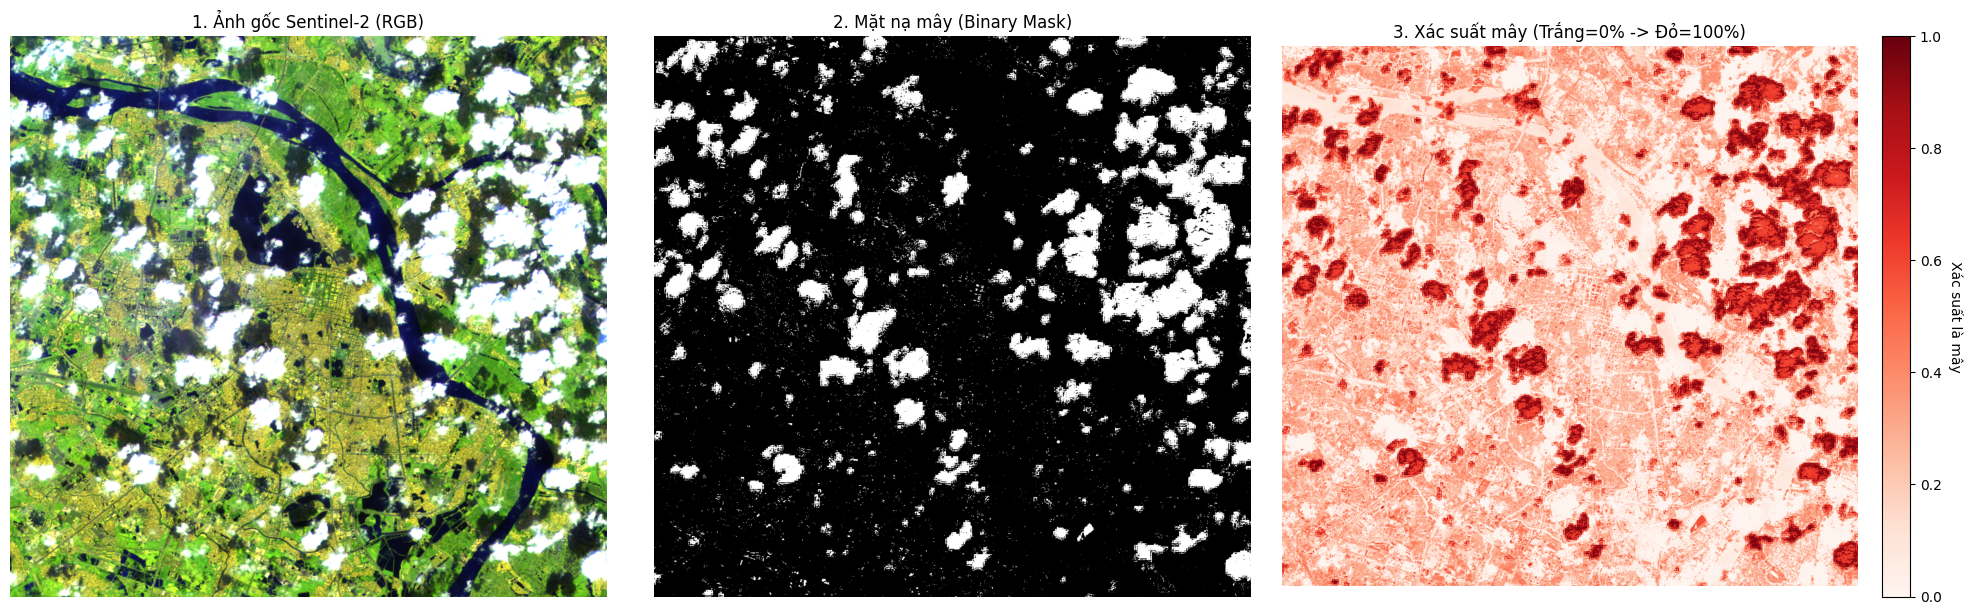

Hoàn tất!


In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import joblib
import pandas as pd


image_path = '../data/cloud_test.tif'
model_path = '../models/S1S2_cloud_RF_model.pkl'

feature_cols = [
    'B2', 'B3', 'B4', 'B8', 'B8A', 'B11', 'B12',
    'NDVI', 'NDWI', 'NDSI', 'BRIGHT',
    'VV', 'VH', 'VV_minus_VH'
]

# 2. HÀM DỰ ĐOÁN VÀ XỬ LÝ ẢNH
def predict_rf_image(image_path, model_path, feature_cols):
    print("Đang tải mô hình Random Forest...")
    try:
        model = joblib.load(model_path)
        print("Đã tải model thành công!")
    except FileNotFoundError:
        print(f"LỖI: Không tìm thấy file model tại {model_path}")
        return None, None, None

    print(f"Đang đọc ảnh từ: {image_path}...")
    with rasterio.open(image_path) as src:
        img_data = src.read()
        height, width = img_data.shape[1], img_data.shape[2]
        num_bands_input = img_data.shape[0]

        print(f"Kích thước ảnh: {width}x{height}")
        print(f"Số bands gốc: {num_bands_input}")

        if num_bands_input < 9:
            raise ValueError("File TIF thiếu band! Cần ít nhất 9 band gốc (Optical + SAR).")

        # A. TRÍCH XUẤT CÁC BAND GỐC
        b2  = img_data[0].astype(float)
        b3  = img_data[1].astype(float)
        b4  = img_data[2].astype(float)
        b8  = img_data[3].astype(float)
        b8a = img_data[4].astype(float)
        b11 = img_data[5].astype(float)
        b12 = img_data[6].astype(float)
        vv  = img_data[7].astype(float)
        vh  = img_data[8].astype(float)

        # B. TÍNH TOÁN CÁC CHỈ SỐ
        print("Đang tính toán các chỉ số (NDVI, NDWI...)...")
        np.seterr(divide='ignore', invalid='ignore') # Bỏ qua lỗi chia cho 0

        # 1. NDVI
        ndvi = (b8 - b4) / (b8 + b4)
        # 2. NDWI
        ndwi = (b3 - b8) / (b3 + b8)
        # 3. NDSI
        ndsi = (b3 - b11) / (b3 + b11)
        # 4. BRIGHT
        bright = (b2 + b3 + b4 + b8) / 4.0
        # 5. VV - VH
        vv_minus_vh = vv - vh

        # Xử lý NaN (do chia 0) thành 0
        ndvi = np.nan_to_num(ndvi)
        ndwi = np.nan_to_num(ndwi)
        ndsi = np.nan_to_num(ndsi)
        bright = np.nan_to_num(bright)

        # C. GỘP DỮ LIỆU ĐỂ DỰ ĐOÁN
        # Stack theo đúng thứ tự feature_cols
        features_stack = np.stack([
            b2, b3, b4, b8, b8a, b11, b12,
            ndvi, ndwi, ndsi, bright,
            vv, vh, vv_minus_vh
        ], axis=0)

        # Reshape: (Features, H, W) -> (H*W, Features)
        X_predict = features_stack.reshape(features_stack.shape[0], -1).T

        # Chuyển thành DataFrame
        X_df = pd.DataFrame(X_predict, columns=feature_cols)
        X_df = X_df.fillna(0)

    print("Đang chạy dự đoán (Random Forest)...")
    # Dự đoán nhãn (0/1)
    y_pred = model.predict(X_df)

    # Dự đoán xác suất (Probability map)
    y_proba = model.predict_proba(X_df)[:, 1]

    # Reshape lại thành ảnh 2D
    mask_pred = y_pred.reshape(height, width)
    proba_map = y_proba.reshape(height, width)

    # Tạo ảnh RGB để hiển thị (B4, B3, B2)
    rgb = np.dstack((b4, b3, b2))
    rgb = np.clip(rgb / 3000, 0, 1)

    return rgb, mask_pred, proba_map

# 3. CHẠY THỬ VÀ VẼ HÌNH
try:
    rgb_img, cloud_mask, cloud_prob = predict_rf_image(image_path, model_path, feature_cols)

    if rgb_img is not None:
        print("Đang vẽ kết quả...")
        fig, axes = plt.subplots(1, 3, figsize=(20, 6))

        # 1. Ảnh vệ tinh thực (RGB)
        axes[0].imshow(rgb_img)
        axes[0].set_title("1. Ảnh gốc Sentinel-2 (RGB)")
        axes[0].axis('off')

        # 2. Kết quả Mask (Nhị phân)
        # 0 (Không mây) = Đen, 1 (Mây) = Trắng
        axes[1].imshow(cloud_mask, cmap='gray')
        axes[1].set_title("2. Mặt nạ mây (Binary Mask)")
        axes[1].axis('off')

        # 3. Kết quả Xác suất
        # cmap='Reds': Giá trị 0 là màu Trắng, 1 là màu Đỏ
        im = axes[2].imshow(cloud_prob, cmap='Reds', vmin=0, vmax=1)
        axes[2].set_title("3. Xác suất mây (Trắng=0% -> Đỏ=100%)")

        # Thêm thanh màu
        cbar = plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)
        cbar.set_label('Xác suất là mây', rotation=270, labelpad=15)

        axes[2].axis('off')

        plt.tight_layout()
        plt.show()

        print("Hoàn tất!")

except Exception as e:
    print(f"Có lỗi xảy ra trong quá trình chạy: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Đang đọc dữ liệu từ: /content/drive/MyDrive/S1S2_cloud_training_samples_Ha_Noi City.csv...
Đã tải dữ liệu thành công!
Kích thước dữ liệu: (68000, 18)
Train size: 47600
Test size: 20400

Bắt đầu quá trình Tuning tham số cho XGBoost...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

 THAM SỐ TỐT NHẤT TÌM ĐƯỢC (XGBoost):
{'subsample': 0.8, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8}

--- Đánh giá mô hình trên tập Test ---
 Độ chính xác (Accuracy): 0.9586

📄 Classification Report:
               precision    recall  f1-score   support

Non-Cloud (0)       0.96      0.97      0.96     11933
    Cloud (1)       0.96      0.94      0.95      8467

     accuracy                           0.96     20400
    macro avg       0.96      0.96      0.96     20400
 weighted avg       0.96      0.96      0.96

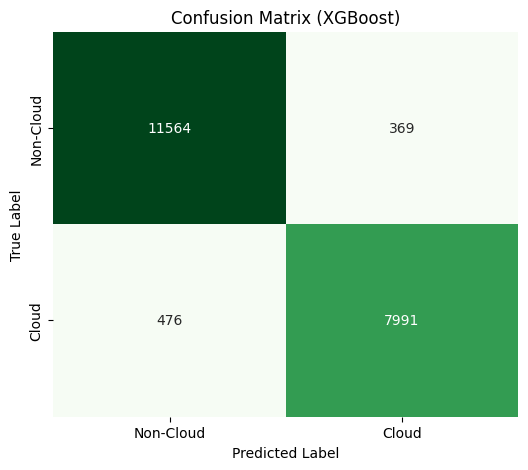


 Feature Importance (XGBoost):
        Feature  Importance
0            B2    0.507169
1        BRIGHT    0.158708
2            B3    0.088666
3          NDVI    0.031929
4            VH    0.028599
5           B8A    0.027968
6            VV    0.027654
7          NDSI    0.022753
8   VV_minus_VH    0.020786
9           B12    0.019700
10          B11    0.019350
11           B8    0.016811
12           B4    0.016530
13         NDWI    0.013379

 Đã lưu biểu đồ tại: /content/drive/MyDrive/XGBoost_Feature_Importance.png


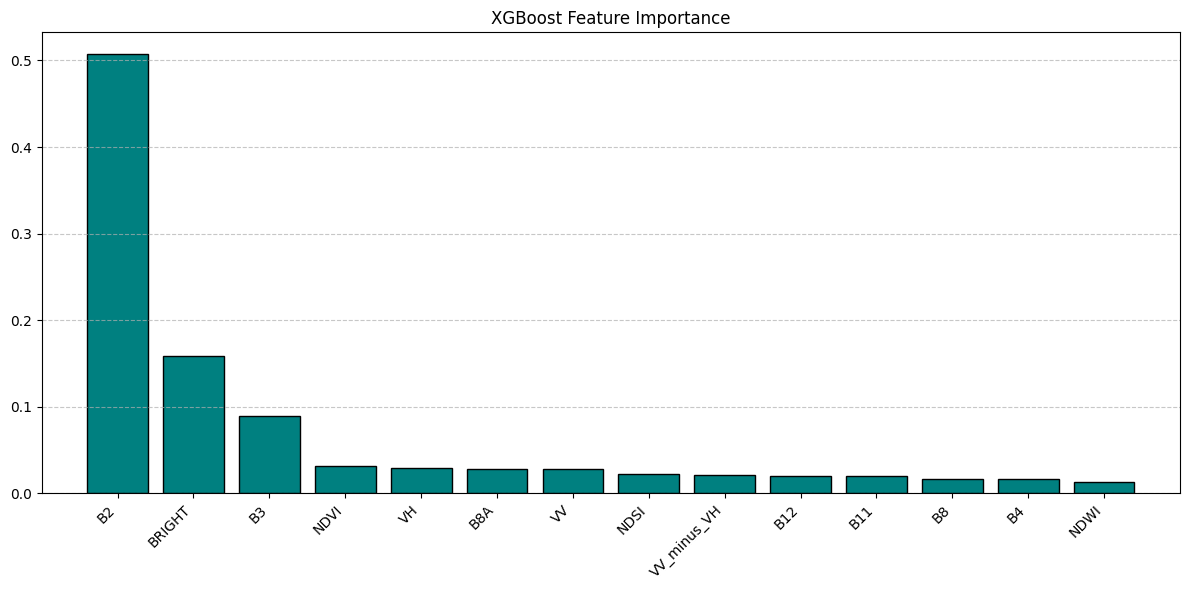

 Đã lưu mô hình XGBoost tại: /content/drive/MyDrive/S1S2_XGBoost_model.pkl


In [ ]:
# XGBoost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import xgboost as xgb

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

# KẾT NỐI GOOGLE DRIVE & TẢI DỮ LIỆU
file_path = '../data/S1S2_cloud_training_samples_Ha_Noi_City.csv'

print(f"Đang đọc dữ liệu từ: {file_path}...")
try:
    df = pd.read_csv(file_path)
    print("Đã tải dữ liệu thành công!")
    print(f"Kích thước dữ liệu: {df.shape}")
except FileNotFoundError:
    print("LỖI: Không tìm thấy file. Vui lòng kiểm tra lại đường dẫn.")

# TIỀN XỬ LÝ DỮ LIỆU
feature_cols = [
    'B2', 'B3', 'B4', 'B8', 'B8A', 'B11', 'B12',
    'NDVI', 'NDWI', 'NDSI', 'BRIGHT',
    'VV', 'VH', 'VV_minus_VH'
]
target_col = 'label'

X = df[feature_cols]
y = df[target_col]
X = X.fillna(0)

# Chia tập Train / Test (70% Train - 30% Test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Train size: {X_train.shape[0]}")
print(f"Test size: {X_test.shape[0]}")

# HYPERPARAMETER TUNING
print("\nBắt đầu quá trình Tuning tham số cho XGBoost...")
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    seed=42,
    eval_metric='logloss',
    tree_method='hist'
)

# Thiết lập lưới tham số để tìm kiếm
param_dist = {
    'n_estimators': [100, 200, 300],        # Số lượng cây
    'learning_rate': [0.01, 0.05, 0.1, 0.2],# Tốc độ học (shrinkage)
    'max_depth': [3, 5, 7, 10],             # Độ sâu tối đa của cây
    'subsample': [0.6, 0.8, 1.0],           # Tỷ lệ mẫu dùng cho mỗi cây
    'colsample_bytree': [0.6, 0.8, 1.0],    # Tỷ lệ đặc trưng dùng cho mỗi cây
    'gamma': [0, 0.1, 0.2],                 # Mức giảm loss tối thiểu để chia nút
}

# Sử dụng RandomizedSearchCV
xgb_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=20,          # Số tổ hợp thử nghiệm
    scoring='accuracy',
    cv=3,               # Cross-validation 3-fold
    verbose=1,
    random_state=42,
    n_jobs=-1
)

xgb_search.fit(X_train, y_train)

# Lấy tham số tốt nhất
best_params = xgb_search.best_params_
best_xgb_model = xgb_search.best_estimator_

print("\n THAM SỐ TỐT NHẤT TÌM ĐƯỢC (XGBoost):")
print(best_params)

# ĐÁNH GIÁ MÔ HÌNH
print("\n--- Đánh giá mô hình trên tập Test ---")
y_pred = best_xgb_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f" Độ chính xác (Accuracy): {acc:.4f}")
print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Cloud (0)', 'Cloud (1)']))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Non-Cloud', 'Cloud'],
            yticklabels=['Non-Cloud', 'Cloud'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (XGBoost)')
plt.show()

# FEATURE IMPORTANCE
importances = best_xgb_model.feature_importances_
indices = np.argsort(importances)[::-1]

print("\n Feature Importance (XGBoost):")
feature_imp_df = pd.DataFrame({
    'Feature': [feature_cols[i] for i in indices],
    'Importance': importances[indices]
})
print(feature_imp_df)

plt.figure(figsize=(12, 6))
plt.title("XGBoost Feature Importance")
plt.bar(range(X.shape[1]), importances[indices], align="center", color='teal', edgecolor='black')
plt.xticks(range(X.shape[1]), [feature_cols[i] for i in indices], rotation=45, ha='right')
plt.xlim([-1, X.shape[1]])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

output_img_path = '../outputs/XGBoost_Feature_Importance.png'
plt.savefig(output_img_path, dpi=300)
print(f"\n Đã lưu biểu đồ tại: {output_img_path}")
plt.show()

# LƯU MÔ HÌNH
model_path = '../models/S1S2_XGBoost_model.pkl'
joblib.dump(best_xgb_model, model_path)
print(f" Đã lưu mô hình XGBoost tại: {model_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Đang đọc dữ liệu từ: /content/drive/MyDrive/S1S2_cloud_training_samples_Ha_Noi City.csv...
 Đã tải dữ liệu thành công!

 Đang chuẩn hóa dữ liệu (StandardScaler)...
Đã chuẩn hóa xong.

 Đang huấn luyện mô hình SVM (Cấu hình mặc định)...
[LibSVM] Huấn luyện hoàn tất sau: 21.36 giây

--- Kết quả đánh giá trên tập Test ---
Độ chính xác (Accuracy): 0.9405

📄 Classification Report:
               precision    recall  f1-score   support

Non-Cloud (0)       0.93      0.97      0.95     11933
    Cloud (1)       0.95      0.90      0.93      8467

     accuracy                           0.94     20400
    macro avg       0.94      0.94      0.94     20400
 weighted avg       0.94      0.94      0.94     20400



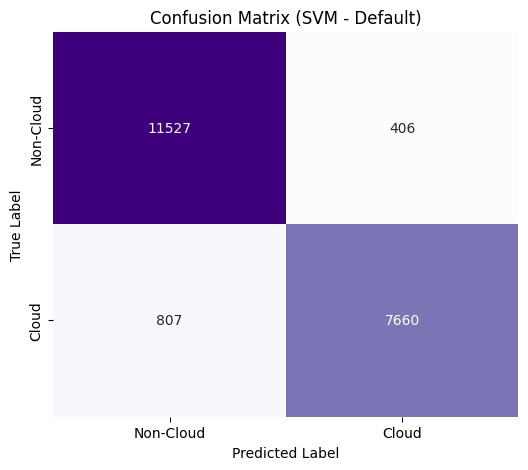


 Đang tính Feature Importance (Mất khoảng 1-2 phút)...
        Feature  Importance
0            B2    0.295784
1           B8A    0.263922
2          NDWI    0.073333
3        BRIGHT    0.066176
4           B11    0.049490
5          NDSI    0.039284
6          NDVI    0.034412
7           B12    0.032255
8            B4    0.031716
9            VV    0.018794
10           B8    0.018755
11           VH    0.014833
12  VV_minus_VH    0.012235
13           B3    0.006804


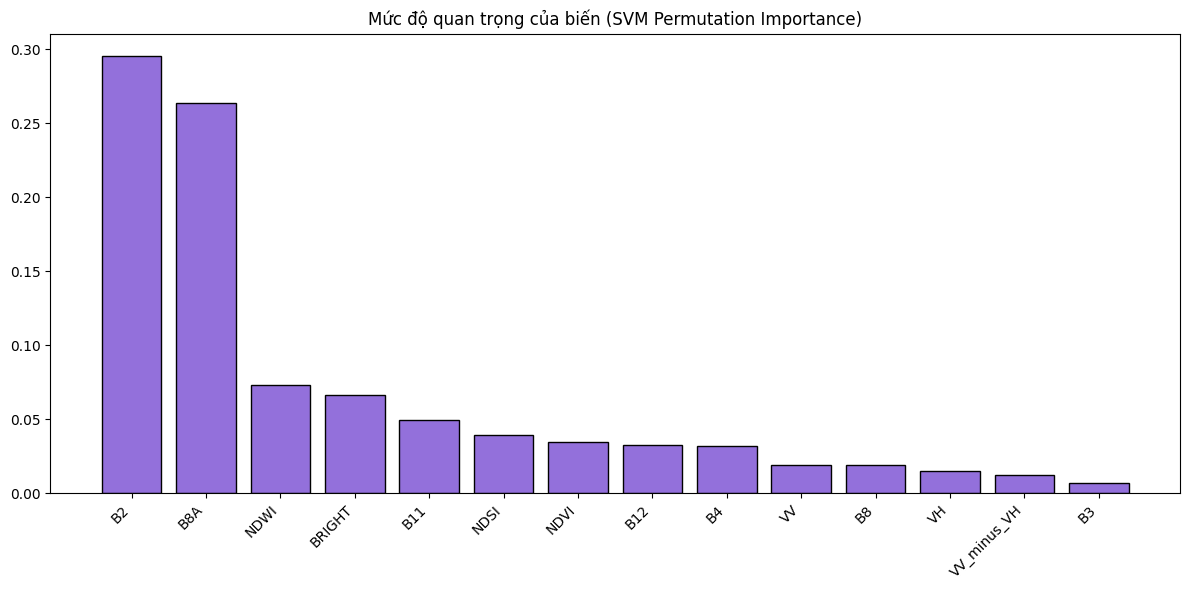


 Đã lưu model và scaler.


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance

file_path = '../data/S1S2_cloud_training_samples_Ha_Noi_City.csv'

print(f" Đang đọc dữ liệu từ: {file_path}...")
try:
    df = pd.read_csv(file_path)
    print(" Đã tải dữ liệu thành công!")
except FileNotFoundError:
    print(" LỖI: Không tìm thấy file. Kiểm tra lại đường dẫn.")

feature_cols = [
    'B2', 'B3', 'B4', 'B8', 'B8A', 'B11', 'B12',
    'NDVI', 'NDWI', 'NDSI', 'BRIGHT',
    'VV', 'VH', 'VV_minus_VH'
]
target_col = 'label'

X = df[feature_cols].fillna(0)
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("\n Đang chuẩn hóa dữ liệu (StandardScaler)...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Đã chuẩn hóa xong.")
print("\n Đang huấn luyện mô hình SVM (Cấu hình mặc định)...")
start_time = time.time()
svm_model = SVC(
    kernel='rbf',       # Kernel phổ biến nhất cho bài toán phi tuyến
    C=1.0,              # Tham số mặc định
    gamma='scale',      # Tự động tính gamma
    random_state=42,
    cache_size=1000,    # Tăng bộ nhớ đệm để chạy nhanh hơn
    verbose=True
)

svm_model.fit(X_train_scaled, y_train)

print(f" Huấn luyện hoàn tất sau: {time.time() - start_time:.2f} giây")
print("\n--- Kết quả đánh giá trên tập Test ---")
y_pred = svm_model.predict(X_test_scaled)

acc = accuracy_score(y_test, y_pred)
print(f"Độ chính xác (Accuracy): {acc:.4f}")
print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Cloud (0)', 'Cloud (1)']))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=False,
            xticklabels=['Non-Cloud', 'Cloud'],
            yticklabels=['Non-Cloud', 'Cloud'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (SVM - Default)')
plt.show()
print("\n Đang tính Feature Importance (Mất khoảng 1-2 phút)...")
perm_importance = permutation_importance(
    svm_model, X_test_scaled, y_test, n_repeats=5, random_state=42, n_jobs=-1
)

sorted_idx = perm_importance.importances_mean.argsort()[::-1]
feature_imp_df = pd.DataFrame({
    'Feature': [feature_cols[i] for i in sorted_idx],
    'Importance': perm_importance.importances_mean[sorted_idx]
})
print(feature_imp_df)

plt.figure(figsize=(12, 6))
plt.title("Mức độ quan trọng của biến (SVM Permutation Importance)")
plt.bar(range(X.shape[1]), perm_importance.importances_mean[sorted_idx], align="center", color='mediumpurple', edgecolor='black')
plt.xticks(range(X.shape[1]), [feature_cols[i] for i in sorted_idx], rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../outputs/SVM_Default_Feature_Importance.png', dpi=300)
plt.show()
joblib.dump(svm_model, '../models/S1S2_SVM_Default_model.pkl')
joblib.dump(scaler, '../models/S1S2_SVM_scaler.pkl')
print("\n Đã lưu model và scaler.")

Đang tải ảnh và mô hình...
Kích thước ảnh: 2133x2004
Số bands đầu vào (từ file TIF): 29
Đã tạo đủ 14 features cho model.
Đang thực hiện dự đoán (Predicting)...
Đang vẽ kết quả...


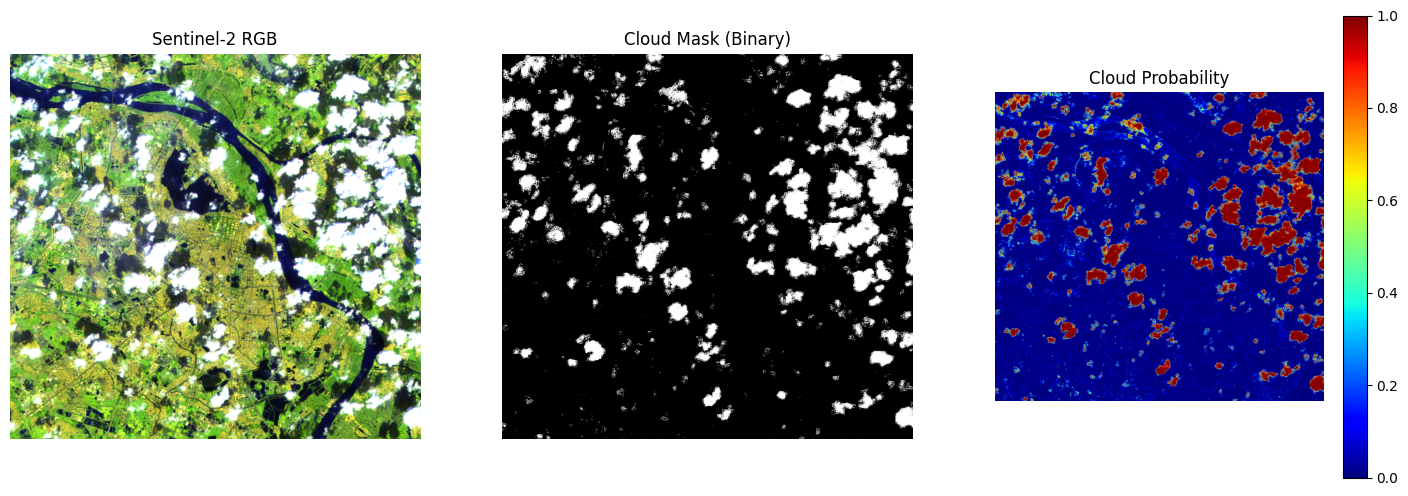

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import joblib
import pandas as pd

image_path = '../data/cloud_test.tif'
model_path = '../models/S1S2_XGBoost_model.pkl'

# Danh sách features model YÊU CẦU (14 features)
feature_cols = [
    'B2', 'B3', 'B4', 'B8', 'B8A', 'B11', 'B12',
    'NDVI', 'NDWI', 'NDSI', 'BRIGHT',
    'VV', 'VH', 'VV_minus_VH'
]

# 2. HÀM DỰ ĐOÁN
def predict_satellite_image(image_path, model_path, feature_cols):
    print("Đang tải ảnh và mô hình...")
    model = joblib.load(model_path)

    with rasterio.open(image_path) as src:
        img_data = src.read()
        profile = src.profile
        height, width = img_data.shape[1], img_data.shape[2]
        num_bands_input = img_data.shape[0]

        print(f"Kích thước ảnh: {width}x{height}")
        print(f"Số bands đầu vào (từ file TIF): {num_bands_input}")

        if num_bands_input < 9:
            raise ValueError(f"File TIF thiếu band! Cần ít nhất 9 band gốc (B2..B12, VV, VH). File hiện tại chỉ có {num_bands_input}.")

        # Tách các band
        b2  = img_data[0].astype(float)
        b3  = img_data[1].astype(float)
        b4  = img_data[2].astype(float)
        b8  = img_data[3].astype(float)
        b8a = img_data[4].astype(float)
        b11 = img_data[5].astype(float)
        b12 = img_data[6].astype(float)
        vv  = img_data[7].astype(float)
        vh  = img_data[8].astype(float)

        # Tránh lỗi chia cho 0
        np.seterr(divide='ignore', invalid='ignore')

        # 1. NDVI
        ndvi = (b8 - b4) / (b8 + b4)

        # 2. NDWI
        ndwi = (b3 - b8) / (b3 + b8)

        # 3. NDSI
        ndsi = (b3 - b11) / (b3 + b11)

        # 4. BRIGHT (Độ sáng)
        bright = (b2 + b3 + b4 + b8) / 4.0

        # 5. VV - VH
        vv_minus_vh = vv - vh

        # Thay thế các giá trị vô cùng/NaN (do chia 0) bằng 0
        ndvi = np.nan_to_num(ndvi)
        ndwi = np.nan_to_num(ndwi)
        ndsi = np.nan_to_num(ndsi)
        bright = np.nan_to_num(bright)

        # GỘP CÁC FEATURES LẠI THEO ĐÚNG THỨ TỰ TRAINING
        features_stack = np.stack([
            b2, b3, b4, b8, b8a, b11, b12,  # Raw Optical
            ndvi, ndwi, ndsi, bright,       # Indices
            vv, vh, vv_minus_vh             # Radar
        ], axis=0) # Stack theo chiều band

        print(f"Đã tạo đủ {features_stack.shape[0]} features cho model.")

        # Reshape: (Features, H, W) -> (H*W, Features)
        X_predict = features_stack.reshape(features_stack.shape[0], -1).T

        # Tạo DataFrame
        X_df = pd.DataFrame(X_predict, columns=feature_cols)
        X_df = X_df.fillna(0)

    print("Đang thực hiện dự đoán (Predicting)...")
    y_pred = model.predict(X_df)
    y_proba = model.predict_proba(X_df)[:, 1]

    # Reshape về kích thước ảnh
    mask_pred = y_pred.reshape(height, width)
    proba_map = y_proba.reshape(height, width)

    # Tạo ảnh RGB để hiển thị
    rgb = np.dstack((b4, b3, b2))
    rgb = np.clip(rgb / 3000, 0, 1)

    return rgb, mask_pred, proba_map

# 3. CHẠY THỬ
try:
    rgb_img, cloud_mask, cloud_prob = predict_satellite_image(image_path, model_path, feature_cols)

    # Vẽ hình
    print("Đang vẽ kết quả...")
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # RGB
    axes[0].imshow(rgb_img)
    axes[0].set_title("Sentinel-2 RGB")
    axes[0].axis('off')

    # Prediction Mask
    axes[1].imshow(cloud_mask, cmap='binary_r') # 0: Đen (k mây), 1: Trắng (mây)
    axes[1].set_title("Cloud Mask (Binary)")
    axes[1].axis('off')

    # Probability
    im = axes[2].imshow(cloud_prob, cmap='jet', vmin=0, vmax=1)
    axes[2].set_title("Cloud Probability")
    plt.colorbar(im, ax=axes[2])
    axes[2].axis('off')

    plt.show()

except Exception as e:
    print(f"Lỗi chi tiết: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Đang đọc dữ liệu từ: /content/drive/MyDrive/S1S2_cloud_training_samples_Ha_Noi City.csv...
Đã tải dữ liệu thành công!

 Đang chuẩn hóa dữ liệu (StandardScaler)...
 Đã chuẩn hóa xong.

 Tập train quá lớn (47600 mẫu).

 Bắt đầu Grid Search (Tìm kiếm tham số tối ưu)...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

 Tuning hoàn tất sau: 6.00 giây
 Best Parameters: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
 Best Cross-Val Score: 0.9408

 Đang huấn luyện lại model trên TOÀN BỘ tập Train với tham số tốt nhất...
 Huấn luyện full dataset hoàn tất sau: 164.90 giây

--- Kết quả đánh giá trên tập Test (Tuned Model) ---
 Độ chính xác (Accuracy): 0.9475

 Classification Report:
               precision    recall  f1-score   support

Non-Cloud (0)       0.95      0.97      0.96     11933
    Cloud (1)       0.95      0.92      0.94      8467

     accuracy  

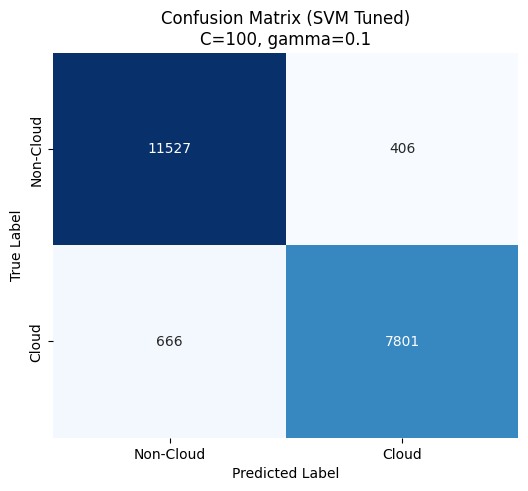


 Đang tính Feature Importance (Permutation)...


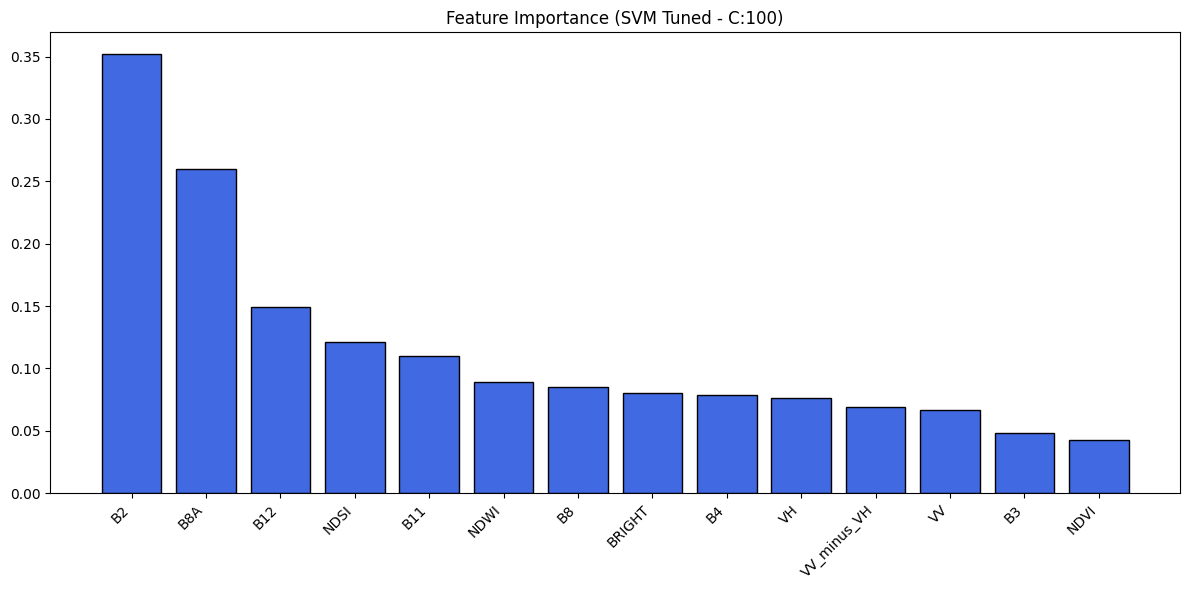


 Đã lưu model tối ưu vào: /content/drive/MyDrive/S1S2_SVM_Tuned_C100.pkl


In [ ]:
# SVM

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance

file_path = '../data/S1S2_cloud_training_samples_Ha_Noi_City.csv'
print(f"Đang đọc dữ liệu từ: {file_path}...")
try:
    df = pd.read_csv(file_path)
    print("Đã tải dữ liệu thành công!")
except FileNotFoundError:
    print("LỖI: Không tìm thấy file. Kiểm tra lại đường dẫn.")
    raise
feature_cols = [
    'B2', 'B3', 'B4', 'B8', 'B8A', 'B11', 'B12',
    'NDVI', 'NDWI', 'NDSI', 'BRIGHT',
    'VV', 'VH', 'VV_minus_VH'
]
target_col = 'label'

# Xử lý NaN
X = df[feature_cols].fillna(0)
y = df[target_col]

# Chia tập Train/Test (70/30)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("\n Đang chuẩn hóa dữ liệu (StandardScaler)...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(" Đã chuẩn hóa xong.")

# Lấy mẫu ngẫu nhiên 5000 điểm từ tập train để tuning
SUBSET_SIZE = 5000
if len(X_train_scaled) > SUBSET_SIZE:
    print(f"\n Tập train quá lớn ({len(X_train_scaled)} mẫu).")
    # Lấy index ngẫu nhiên
    idx_sub = np.random.choice(range(len(X_train_scaled)), SUBSET_SIZE, replace=False)
    X_train_sub = X_train_scaled[idx_sub]
    y_train_sub = y_train.iloc[idx_sub]
else:
    X_train_sub = X_train_scaled
    y_train_sub = y_train

# Thiết lập lưới tham số
param_grid = {
    'C': [0.1, 1, 10, 100],            # C càng lớn càng phạt lỗi mạnh (dễ overfit)
    'gamma': ['scale', 0.1, 0.01],     # Gamma kiểm soát độ cong của biên giới hạn
    'kernel': ['rbf']                  # RBF là tốt nhất cho dữ liệu viễn thám
}

print("\n Bắt đầu Grid Search (Tìm kiếm tham số tối ưu)...")
start_tune = time.time()

grid = GridSearchCV(
    SVC(),
    param_grid,
    refit=True,     # Tự động train lại model tốt nhất trên tập mẫu con
    verbose=2,
    cv=3,           # Cross-validation 3 lần
    n_jobs=-1       # Dùng tất cả nhân CPU để chạy song song
)

grid.fit(X_train_sub, y_train_sub)

print(f"\n Tuning hoàn tất sau: {time.time() - start_tune:.2f} giây")
print(f" Best Parameters: {grid.best_params_}")
print(f" Best Cross-Val Score: {grid.best_score_:.4f}")

# HUẤN LUYỆN LẠI TRÊN TOÀN BỘ DỮ LIỆU
print("\n Đang huấn luyện lại model trên TOÀN BỘ tập Train với tham số tốt nhất...")
start_train = time.time()
best_svm = SVC(
    C=grid.best_params_['C'],
    gamma=grid.best_params_['gamma'],
    kernel=grid.best_params_['kernel'],
    random_state=42,
    probability=True,  # Bật tính năng xác suất
    cache_size=2000
)

best_svm.fit(X_train_scaled, y_train)

print(f" Huấn luyện full dataset hoàn tất sau: {time.time() - start_train:.2f} giây")
print("\n--- Kết quả đánh giá trên tập Test (Tuned Model) ---")
y_pred = best_svm.predict(X_test_scaled)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f" Độ chính xác (Accuracy): {acc:.4f}")
print("\n Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Cloud (0)', 'Cloud (1)']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Cloud', 'Cloud'],
            yticklabels=['Non-Cloud', 'Cloud'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f"Confusion Matrix (SVM Tuned)\nC={grid.best_params_['C']}, gamma={grid.best_params_['gamma']}")
plt.show()

# TÍNH FEATURE IMPORTANCE
print("\n Đang tính Feature Importance (Permutation)...")
perm_importance = permutation_importance(
    best_svm, X_test_scaled, y_test, n_repeats=5, random_state=42, n_jobs=-1
)
sorted_idx = perm_importance.importances_mean.argsort()[::-1]

plt.figure(figsize=(12, 6))
plt.title(f"Feature Importance (SVM Tuned - C:{grid.best_params_['C']})")
plt.bar(range(X.shape[1]), perm_importance.importances_mean[sorted_idx],
        align="center", color='royalblue', edgecolor='black')
plt.xticks(range(X.shape[1]), [feature_cols[i] for i in sorted_idx], rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../outputs/SVM_Tuned_Feature_Importance.png', dpi=300)
plt.show()
model_filename = f"../models/S1S2_SVM_model.pkl"
joblib.dump(best_svm, model_filename)
joblib.dump(scaler, '../models/S1S2_SVM_scaler.pkl')

print(f"\n Đã lưu model tối ưu vào: {model_filename}")